In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
path = '/content/drive/MyDrive/chbmit_preprocessed_data.csv'
df = pd.read_csv(path)


In [ ]:
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())


Shape: (2097150, 24)
Columns: ['# FP1-F7', 'C3-P3', 'C4-P4', 'CZ-PZ', 'F3-C3', 'F4-C4', 'F7-T7', 'F8-T8', 'FP1-F3', 'FP2-F4', 'FP2-F8', 'FT10-T8', 'FT9-FT10', 'FZ-CZ', 'P3-O1', 'P4-O2', 'P7-O1', 'P7-T7', 'P8-O2', 'T7-FT9', 'T7-P7', 'T8-P8-0', 'T8-P8-1', 'Outcome']


In [ ]:
print("Class Distribution:")
print(df['Outcome'].value_counts())


Class Distribution:
Outcome
0.0    1048575
1.0    1048575
Name: count, dtype: int64


In [ ]:
# STEP 3: Stratified Train/Val/Test Split (70/15/15)
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Outcome'])
y = df['Outcome']

# First split: Train (70%) and Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42)

# Second split: Val (15%) and Test (15%) from Temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Recombine into DataFrames
train_df = X_train.copy()
train_df['Outcome'] = y_train.values

val_df = X_val.copy()
val_df['Outcome'] = y_val.values

test_df = X_test.copy()
test_df['Outcome'] = y_test.values

print("\nTrain shape:", train_df.shape)
print("Val shape:  ", val_df.shape)
print("Test shape: ", test_df.shape)

print("\nTrain class distribution:\n", train_df['Outcome'].value_counts())
print("Val class distribution:\n", val_df['Outcome'].value_counts())
print("Test class distribution:\n", test_df['Outcome'].value_counts())




Train shape: (1468005, 24)
Val shape:   (314572, 24)
Test shape:  (314573, 24)

Train class distribution:
 Outcome
1.0    734003
0.0    734002
Name: count, dtype: int64
Val class distribution:
 Outcome
1.0    157286
0.0    157286
Name: count, dtype: int64
Test class distribution:
 Outcome
0.0    157287
1.0    157286
Name: count, dtype: int64


In [ ]:
# STEP 4: Normalize features with StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit only on training data
X_train_scaled = scaler.fit_transform(train_df.drop(columns=['Outcome']))
X_val_scaled = scaler.transform(val_df.drop(columns=['Outcome']))
X_test_scaled = scaler.transform(test_df.drop(columns=['Outcome']))

# Rebuild DataFrames
train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
train_df['Outcome'] = y_train.values

val_df = pd.DataFrame(X_val_scaled, columns=X.columns)
val_df['Outcome'] = y_val.values

test_df = pd.DataFrame(X_test_scaled, columns=X.columns)
test_df['Outcome'] = y_test.values

# Final sanity check
print("\nNormalized train_df shape:", train_df.shape)
train_df.head()



Normalized train_df shape: (1468005, 24)


,# FP1-F7,C3-P3,C4-P4,CZ-PZ,F3-C3,F4-C4,F7-T7,F8-T8,FP1-F3,FP2-F4,...,P3-O1,P4-O2,P7-O1,P7-T7,P8-O2,T7-FT9,T7-P7,T8-P8-0,T8-P8-1,Outcome
0,0.405983,-0.148855,0.079405,0.610572,2.183572,0.083976,0.289957,-0.554244,0.465374,0.279419,...,-0.954413,0.013486,-0.006861,-0.968042,0.922671,-1.100968,0.967881,0.592804,0.592804,1.0
1,0.227267,-1.805029,-1.113813,-1.503811,-0.325438,-0.437801,-0.154769,-1.180518,1.127678,0.513061,...,-0.470106,-0.318481,-0.028759,1.051924,-0.122735,0.065994,-1.050590,-0.612419,-0.612419,0.0
2,-0.046789,0.471316,0.136110,0.660369,0.399605,0.633734,0.370081,-0.099840,-0.248617,-0.262002,...,0.537986,0.946405,0.454423,-0.248771,0.940427,-0.160391,0.248679,0.468847,0.468847,0.0
3,0.035187,-0.245570,-0.408835,-0.495704,0.334039,0.086445,-0.089346,-0.657595,-0.454764,-0.244030,...,-0.330116,-0.387083,-0.474199,0.122339,0.130927,-0.207078,-0.122431,-0.584781,-0.584781,0.0
4,0.244362,-0.841811,-0.213731,-0.511327,0.393506,0.325112,-0.325308,-0.227107,0.224618,-0.179629,...,-0.142083,0.023910,-0.490826,-0.399055,-0.047091,0.512449,0.398963,0.170682,0.170682,0.0


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# EEG Dataset
class EEGDataset(Dataset):
    def __init__(self, dataframe):
        self.X = dataframe.drop(columns=['Outcome']).values.astype('float32')
        self.y = dataframe['Outcome'].values.astype('int64')

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.X[idx]
        x = torch.tensor(x).unsqueeze(0)  # (1, 23) sequence
        y = torch.tensor(self.y[idx])
        return x, y


In [ ]:
class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        device = features.device
        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)

        anchor_dot_contrast = torch.div(torch.matmul(features, features.T), self.temperature)
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        exp_logits = torch.exp(logits) * (1 - torch.eye(features.shape[0]).to(device))
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-9)

        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1).clamp(min=1)
        loss = -mean_log_prob_pos.mean()
        return loss


In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * CE_loss

        return loss.mean() if self.reduction == 'mean' else loss.sum()


In [ ]:
class Attention(nn.Module):
    def __init__(self, input_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(input_dim, 1)

    def forward(self, lstm_output):
        weights = torch.softmax(self.attn(lstm_output), dim=1)  # (B, T, 1)
        weighted_output = (lstm_output * weights).sum(dim=1)    # (B, D)
        return weighted_output


In [ ]:
class CNN_BiLSTM_SCL_Attn(nn.Module):
    def __init__(self, input_size=23, hidden_size=128, emb_dim=256, num_classes=2):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3)
        )

        self.lstm = nn.LSTM(input_size=64, hidden_size=hidden_size,
                            num_layers=1, batch_first=True, bidirectional=True)

        self.attn = Attention(input_dim=hidden_size * 2)
        self.emb = nn.Sequential(
            nn.Linear(hidden_size * 2, emb_dim),
            nn.LayerNorm(emb_dim),
            nn.ReLU()
        )

        self.classifier = nn.Linear(emb_dim, num_classes)

    def forward(self, x):  # x: (B, 1, 23)
        b, _, f = x.shape
        x = self.cnn(x)  # → (B, 64, 23)
        x = x.permute(0, 2, 1)  # (B, 23, 64)

        lstm_out, _ = self.lstm(x)  # (B, 23, 2*H)
        attn_output = self.attn(lstm_out)  # (B, 2*H)

        emb = F.normalize(self.emb(attn_output), dim=1)
        logits = self.classifier(emb)
        return logits, emb


In [ ]:
class EEGDataset(Dataset):
    def __init__(self, dataframe, augment=False):
        self.X = dataframe.drop(columns=['Outcome']).values.astype('float32')
        self.y = dataframe['Outcome'].values.astype('int64')
        self.augment = augment

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.augment:
            noise = np.random.normal(0, 0.05, x.shape)
            x = x + noise.astype('float32')
        x = torch.tensor(x).unsqueeze(0)  # (1, 23)
        y = torch.tensor(self.y[idx])
        return x, y
# Create DataLoaders
train_dataset = EEGDataset(train_df, augment=True)
val_dataset   = EEGDataset(val_df, augment=False)
test_dataset  = EEGDataset(test_df, augment=False)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=512, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=512, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN_BiLSTM_SCL_Attn().to(device)
ce_loss_fn = FocalLoss()
scl_loss_fn = SupConLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


CUDA Available: True
GPU Device: Tesla T4


In [ ]:
import numpy as np
epochs = 20  # Training for 20 epochs

best_val_acc = 0.0  # To track best accuracy

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        logits, emb = model(x_batch)
        loss_ce = ce_loss_fn(logits, y_batch)
        loss_scl = scl_loss_fn(emb, y_batch)

        # Total loss: CrossEntropy + weighted SCL
        loss = loss_ce + 0.5 * loss_scl

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"[Epoch {epoch+1}] Train Loss: {total_loss:.4f}")

    # ===== Validation =====
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            logits, emb = model(x_val)

            loss_ce = ce_loss_fn(logits, y_val)
            loss_scl = scl_loss_fn(emb, y_val)
            loss = loss_ce + 0.5 * loss_scl
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            correct += (preds == y_val).sum().item()
            total += y_val.size(0)

    val_acc = correct / total
    print(f"           Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_cnn_bilstm_scl_model.pth")
        print(f"           ✅ Saved new best model (val acc: {val_acc:.4f})")


[Epoch 1] Train Loss: 9157.5190
           Val Loss: 1953.1056 | Val Accuracy: 0.8001
           ✅ Saved new best model (val acc: 0.8001)
[Epoch 2] Train Loss: 9104.0246
           Val Loss: 1948.8926 | Val Accuracy: 0.8069
           ✅ Saved new best model (val acc: 0.8069)
[Epoch 3] Train Loss: 9088.9927
           Val Loss: 1945.9608 | Val Accuracy: 0.8106
           ✅ Saved new best model (val acc: 0.8106)
[Epoch 4] Train Loss: 9076.1395
           Val Loss: 1945.1338 | Val Accuracy: 0.8095
[Epoch 5] Train Loss: 9063.1482
           Val Loss: 1943.0880 | Val Accuracy: 0.8136
           ✅ Saved new best model (val acc: 0.8136)
[Epoch 6] Train Loss: 9051.1906
           Val Loss: 1938.7520 | Val Accuracy: 0.8181
           ✅ Saved new best model (val acc: 0.8181)
[Epoch 7] Train Loss: 9041.5453
           Val Loss: 1937.2276 | Val Accuracy: 0.8215
           ✅ Saved new best model (val acc: 0.8215)
[Epoch 8] Train Loss: 9032.4178
           Val Loss: 1937.6608 | Val Accuracy: 0.8200


In [ ]:
# Load best model from previous run
model.load_state_dict(torch.load("best_cnn_bilstm_scl_model.pth"))

# Continue training from epoch 21 to 30
for epoch in range(21, 31):
    model.train()
    total_loss = 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        logits, emb = model(x_batch)
        loss_ce = ce_loss_fn(logits, y_batch)
        loss_scl = scl_loss_fn(emb, y_batch)
        loss = loss_ce + 0.5 * loss_scl

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"[Epoch {epoch}] Train Loss: {total_loss:.4f}")

    # ===== Validation =====
    model.eval()
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            logits, emb = model(x_val)

            loss_ce = ce_loss_fn(logits, y_val)
            loss_scl = scl_loss_fn(emb, y_val)
            loss = loss_ce + 0.5 * loss_scl
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            correct += (preds == y_val).sum().item()
            total += y_val.size(0)

    val_acc = correct / total
    print(f"           Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_cnn_bilstm_scl_model.pth")
        print(f"           ✅ Saved new best model (val acc: {val_acc:.4f})")


[Epoch 21] Train Loss: 8956.3597
           Val Loss: 1917.2550 | Val Accuracy: 0.8474
           ✅ Saved new best model (val acc: 0.8474)
[Epoch 22] Train Loss: 8951.7396
           Val Loss: 1916.6957 | Val Accuracy: 0.8473
[Epoch 23] Train Loss: 8947.4043
           Val Loss: 1916.0088 | Val Accuracy: 0.8498
           ✅ Saved new best model (val acc: 0.8498)
[Epoch 24] Train Loss: 8942.8423
           Val Loss: 1915.0908 | Val Accuracy: 0.8478
[Epoch 25] Train Loss: 8938.7067
           Val Loss: 1915.1824 | Val Accuracy: 0.8487
[Epoch 26] Train Loss: 8934.9472
           Val Loss: 1912.2102 | Val Accuracy: 0.8526
           ✅ Saved new best model (val acc: 0.8526)
[Epoch 27] Train Loss: 8931.6361
           Val Loss: 1912.2671 | Val Accuracy: 0.8512
[Epoch 28] Train Loss: 8927.7109
           Val Loss: 1911.3256 | Val Accuracy: 0.8537
           ✅ Saved new best model (val acc: 0.8537)
[Epoch 29] Train Loss: 8924.2784
           Val Loss: 1912.0468 | Val Accuracy: 0.8512
[Epoch 30


✅ Test Accuracy: 0.8573

📄 Classification Report:
               precision    recall  f1-score   support

           0     0.8197    0.9160    0.8652    157287
           1     0.9048    0.7986    0.8484    157286

    accuracy                         0.8573    314573
   macro avg     0.8623    0.8573    0.8568    314573
weighted avg     0.8623    0.8573    0.8568    314573



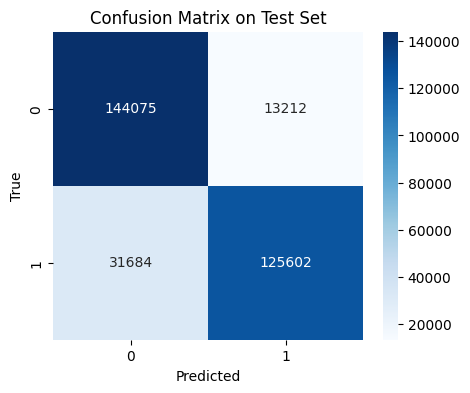

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load best model weights
model.load_state_dict(torch.load("best_cnn_bilstm_scl_model.pth"))
model.eval()

y_true = []
y_pred = []

# Run on test set
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        logits, _ = model(x_test)
        preds = torch.argmax(logits, dim=1)

        y_true.extend(y_test.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# 🟢 Accuracy
test_acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")

# 🧾 Classification Report
print("\n📄 Classification Report:\n", classification_report(y_true, y_pred, digits=4))

# 🔷 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Test Set")
plt.show()
